![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [23]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [24]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [25]:
y_test.isna().any()

False

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [27]:

max_depth = None
num_pct = 10
max_features = None
min_gain=0.001
# estos son los parámetros y criterios de parada

#gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)


    #gini_imputiry según la materia:
    
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

#best_split para mejor bofurcación y variable
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

#tree_grow para crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    #1 observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    #Mejor split
    j, split, gain = best_split(X, y, num_pct)
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    #División o partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    #en cada partición  
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)  
    return tree

#tree_predict
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

In [28]:
man_tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10)


In [29]:
y_pred = tree_predict(X_test, man_tree)

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular las predicciones del árbol de decisión manual
y_pred_manual_tree = tree_predict(X_test, man_tree)

# Calcular el MSE
mse_manual_tree = mean_squared_error(y_test, y_pred_manual_tree)

# Calcular el MAE
mae_manual_tree = mean_absolute_error(y_test, y_pred_manual_tree)

print("Desempeño del árbol de decisión manual:")
print(f"MSE: {mse_manual_tree}")
print(f"MAE: {mae_manual_tree:.2f}")


Desempeño del árbol de decisión manual:
MSE: 13053199.737009238
MAE: 2054.90


Según el árbol construido vemos que el MSE: 3612.92 y el MAE: 2054.90, esto muestra que tiene un nivel de error importante en slas predicciones sobre el precio de los automóviles.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [59]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def build_bagging(X_train, y_train, n_trees = 10, max_depth=None):

    trees = []

    for i in range(n_trees):
        X_sample, y_sample = resample(X_train, y_train) # Muestreo Boostrapt 
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X_sample, y_sample)
        trees.append(tree)
    
    return trees

def predict_bagging(trees, X):

    predictions = np.array([tree.predict(X) for tree in trees]) # prediciones de cada árbol
    return np.mean(predictions, axis=0)

trees = build_bagging(X_train, y_train)
y_pred = predict_bagging(trees, X_test)

mse_bagging = mean_squared_error(y_test, y_pred)
r2_bagging = r2_score(y_test, y_pred)
mae_bagging = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo Bagging:")
print(f"MSE: {mse_bagging:.2f}")
print(f"MAE: {mae_bagging:.2f}")
print(f"R2: {r2_bagging:.2f}")

Desempeño del modelo Bagging:
MSE: 3191776.60
MAE: 1337.06
R2: 0.79


Con el modelo  bagging manualmente y con 10 árboles de regresión tenemos mayor error al obtenido con el árbol manual ya que el MSE es de 3243507.98 y el MAE de 1343.71


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [60]:
# Celda 3
from sklearn.ensemble import BaggingRegressor


n_trees = 10
max_features = int(np.log(X_train.shape[1]))

bagging_model = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(),
    n_estimators=n_trees,
    max_features=max_features,
    random_state=42
)

bagging_model.fit(X_train, y_train)


y_pred = bagging_model.predict(X_test)

mse_bagging_lib = mean_squared_error(y_test, y_pred)
r2_bagging_lib = r2_score(y_test, y_pred)
mae_bagging_lib = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo bagging_lib:")
print(f"MSE: {mse_bagging_lib:.2f}")
print(f"MAE: {mae_bagging_lib:.2f}")
print(f"R2: {r2_bagging_lib:.2f}")

Desempeño del modelo bagging_lib:
MSE: 7663764.02
MAE: 2160.76
R2: 0.50


El desempeño del modelo bagging_lib es moderado en la predicción del precio de los automóviles, ya que tiene un MAE de 2160.76, un MSE de 7,663,764.02, y también tiene un error mayor que el árbol de decisión manual.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Random Forest para regresión  y comenten sobre el desempeño del modelo.

In [61]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Realizar predicciones sobre el conjunto de prueba
y_pred = rf.predict(X_test)

mse_random_forest = mean_squared_error(y_test, y_pred)
r2_random_forest = r2_score(y_test, y_pred)
mae_random_forest = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo random_forest:")
print(f"MSE: {mse_random_forest:.2f}")
print(f"MAE: {mae_random_forest:.2f}")
print(f"R2: {r2_random_forest:.2f}")

Desempeño del modelo random_forest:
MSE: 3116678.92
MAE: 1314.42
R2: 0.80


El modelo Random Forest presenta un desempeño mejor que los modelos anteriores con:
MSE: 3116678.92
MAE: 1314.42

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [44]:
# Celda 5
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'max_depth': [10, 20, 30, None], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'n_estimators':  [50, 100, 200, 250]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)
print("Mejores parámetros encontrados:", grid_search.best_params_)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos\n")

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)

mse_random_forest_cv = mean_squared_error(y_test, y_pred)
r2_random_forest_cv = r2_score(y_test, y_pred)
mae_random_forest_cv = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo random_forest_cv:")
print(f"MSE: {mse_random_forest_cv:.2f}")
print(f"MAE: {mae_random_forest_cv:.2f}")
print(f"R2: {r2_random_forest_cv:.2f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores parámetros encontrados: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250}
Tiempo de entrenamiento: 38.05 segundos

Desempeño del modelo random_forest_cv:
MSE: 2447939.89
MAE: 1147.02
R2: 0.84


El  modelo random_forest_cv tiene un MSE de 2447939.89 y un MAE de 1147.02, con menor error  en comparación con los modelos anteriores

In [45]:
def analyze_grid_search(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    results['mean_test_score'] = -results['mean_test_score']  # Convertir a MSE positivo

    # Organizar resultados para visualizar el efecto de cada parámetro
    params = pd.DataFrame(results['params'].tolist())
    results = pd.concat([params, results[['mean_test_score', 'std_test_score', 'rank_test_score']]], axis=1)
    return results

# Obtener y analizar los resultados del GridSearchCV
results = analyze_grid_search(grid_search)
results

,max_depth,max_features,n_estimators,mean_test_score,std_test_score,rank_test_score
0,10.0,auto,50,2.428256e+06,150345.403393,12
1,10.0,auto,100,2.419406e+06,146853.412879,11
2,10.0,auto,200,2.417250e+06,147111.306297,10
3,10.0,auto,250,2.414295e+06,145687.770977,9
4,10.0,sqrt,50,2.385725e+06,156209.181796,7
5,10.0,sqrt,100,2.377178e+06,153173.751698,5
6,10.0,sqrt,200,2.367313e+06,153606.538913,3
7,10.0,sqrt,250,2.363413e+06,153651.935168,1
8,10.0,log2,50,2.385725e+06,156209.181796,7
9,10.0,log2,100,2.377178e+06,153173.751698,5


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [47]:
# Celda 6
!pip install xgboost

from xgboost import XGBRegressor

xgb_model = XGBRegressor(objective='reg:squarederror')
start_time = time.time()

xgb_model.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos\n")

y_pred = xgb_model.predict(X_test)

mse_xgboost = mean_squared_error(y_test, y_pred)
r2_xgboost = r2_score(y_test, y_pred)
mae_xgboost = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo xgboost:")
print(f"MSE: {mse_xgboost:.2f}")
print(f"MAE: {mae_xgboost:.2f}")
print(f"R2: {r2_xgboost:.2f}")

     |████████████████████████████████| 2.2 MB 817 kB/s eta 0:00:01
Tiempo de entrenamiento: 0.09 segundos

Desempeño del modelo xgboost:
MSE: 2576781.07
MAE: 1185.23
R2: 0.83


El modelo XGBoost tiene un MSE de 2576781.07, un MAE de 1185.23  y el tiempo de entrenamiento es rápido de 0.11 segundos.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [48]:
# Celda 7

# Definir el modelo base
xgb = XGBRegressor(objective='reg:squarederror', )

param_grid = {
    'learning_rate': [0.01, 0.1, 1],  
    'gamma': [0, 0.01, 0.1, 0.5],          
    'colsample_bytree': [0.3, 0.7, 1.0]  
}


grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"Tiempo de entrenamiento: {training_time:.2f} segundos\n")

print("Mejores parámetros encontrados:", grid_search.best_params_)
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test)

mse_xgboost_cv = mean_squared_error(y_test, y_pred)
r2_xgboost_cv = r2_score(y_test, y_pred)
mae_xgboost_cv = mean_absolute_error(y_test, y_pred)

print("Desempeño del modelo xgboost_cv:")
print(f"MSE: {mse_xgboost_cv:.2f}")
print(f"MAE: {mae_xgboost_cv:.2f}")
print(f"R2: {r2_xgboost_cv:.2f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Tiempo de entrenamiento: 1.26 segundos

Mejores parámetros encontrados: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1}
Desempeño del modelo xgboost_cv:
MSE: 2391571.59
MAE: 1134.03
R2: 0.84


In [49]:
results = analyze_grid_search(grid_search)
results

,colsample_bytree,gamma,learning_rate,mean_test_score,std_test_score,rank_test_score
0,0.3,0.00,0.01,7.880986e+06,205211.688674,33
1,0.3,0.00,0.10,2.454102e+06,116768.981549,9
2,0.3,0.00,1.00,2.626786e+06,32932.241117,13
3,0.3,0.01,0.01,7.880986e+06,205211.688674,33
4,0.3,0.01,0.10,2.454102e+06,116768.981549,9
5,0.3,0.01,1.00,2.626786e+06,32932.241138,14
6,0.3,0.10,0.01,7.880986e+06,205211.688674,33
7,0.3,0.10,0.10,2.454102e+06,116768.981549,9
8,0.3,0.10,1.00,2.626787e+06,32932.295356,15
9,0.3,0.50,0.01,7.880986e+06,205211.688674,33


La calibración de los parámetros del modelo XGBoost muestran combinaciones que afectan el rendimiento tales como learning_rate afectando la velocidad y generalización, 
gamma que maneja la pérdida mínima para dividir nodos 
colsample_bytree reduciendo el sobreajuste al seleccionar características.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

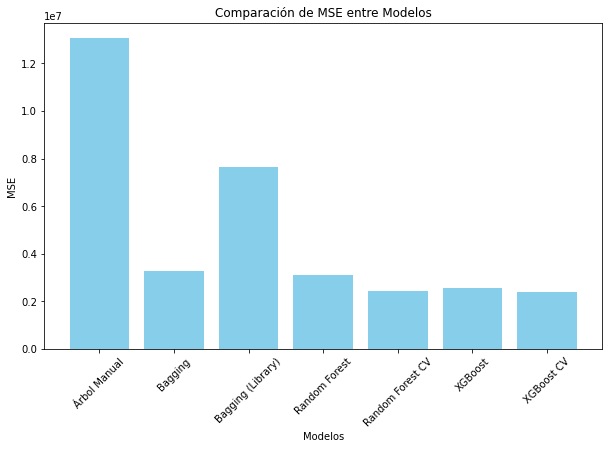

El mejor modelo es XGBoost CV con un MSE de 2391571.59
[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.4s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, max_features=auto, n_estimators=250; total time=   1.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.2s
[CV] END ...max_depth=10, max_features=log2, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END ...max_depth=20, max_features=auto, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=20, max_features=auto, n_estimators=100; total time=   1.0s
[CV] END ..max_depth=20, max_features=auto, n_estimators=200; total time=   2.2s
[CV] END ...max_depth=20, max_features=sqrt, n_estimat

[CV] END ...max_depth=10, max_features=auto, n_estimators=50; total time=   0.3s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, max_features=auto, n_estimators=250; total time=   1.7s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   0.9s
[CV] END ..max_depth=10, max_features=log2, n_estimators=250; total time=   1.0s
[CV] END ...max_depth=20, max_features=auto, n_estimators=50; total time=   0.5s
[CV] END ..max_depth=20, max_features=auto, n_estimators=100; total time=   1.0s
[CV] END ..max_depth=20, max_features=auto, n_estimators=250; total time=   2.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=200; total time=   1.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=250; total time=   1.7s
[CV] END ..max_depth=20, max_features=log2, n_estimators=200; total time=   1.4s
[CV] END ...max_depth=30, ma

[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   0.7s
[CV] END ..max_depth=10, max_features=auto, n_estimators=200; total time=   1.4s
[CV] END ...max_depth=10, max_features=sqrt, n_estimators=50; total time=   0.2s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=10, max_features=sqrt, n_estimators=250; total time=   0.9s
[CV] END ..max_depth=10, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END ..max_depth=10, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END ...max_depth=20, max_features=auto, n_estimators=50; total time=   0.6s
[CV] END ..max_depth=20, max_features=auto, n_estimators=100; total time=   1.0s
[CV] END ..max_depth=20, max_features=auto, n_estimators=250; total time=   2.7s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END ..max_depth=20, max

In [58]:
# Celda 8

import matplotlib.pyplot as plt

mse_scores = {
    'Árbol Manual': mse_manual_tree,
    'Bagging': mse_bagging,
    'Bagging (Library)': mse_bagging_lib,
    'Random Forest': mse_random_forest,
    'Random Forest CV': mse_random_forest_cv,
    'XGBoost': mse_xgboost,
    'XGBoost CV': mse_xgboost_cv
}

models = list(mse_scores.keys())
mse_values = list(mse_scores.values())

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='skyblue')
plt.xlabel('Modelos')
plt.ylabel('MSE')
plt.title('Comparación de MSE entre Modelos')
plt.xticks(rotation=45)
plt.show()

best_model = min(mse_scores, key=mse_scores.get)
best_mse = mse_scores[best_model]

print(f"El mejor modelo es {best_model} con un MSE de {best_mse:.2f}")


El Random Forest con validación cruzada XGBoost CV es el modelo mejor para predecir los precios de los automóviles 

Su capacidad para reducir el sobreajuste y su mejor rendimiento general lo hacen estar sobre otros modelos, como el Árbol de Decisión Manual. 
No obstante requiere requiere ajustar algunos parámetros, su implementación es relativamente sencilla y ofrece resultados más precisos y confiables en comparación con modelos más simples.

En el caso de las desventajas del modelo con menor desempeño que es el Árbol de Decisión Manual: Muestra un alto error de predicción, además  tiene menor sensibilidad a la calidad de los datos
   